Memo: Revisiting Receiver tempearature measurements

Authors: Bharat Gehlot, Tyler Cox and Shane Bechtel


In this memo, we test the accuracy of the method to determine receiver temperature ($T_{rxr}$) of HERA antennas proposed by Adam Beardsley (see HERA memo#16).

This method fits the following template to the auto-correlations:

$\texttt{template}[LST] = G_0 \times (T_{sky}[LST] - \left< T_{sky}\right>) + N_{0}$

where $G_0$ and $N_0$ are the fitting parameters which correspond to the gain and the noise bias term, respectively.
$T_{rxr}$ can be written as:

$T_{rxr} = \dfrac{N_{0}}{G_{0}} - \left< T_{sky}\right>$

When we tested this method to fit $T_{rxr}$ for H1C and H2C observations, we found large discrepencies between the expected and estimated $T_{rxr}$ values. The estimated $T_{rxr}$ values had large variations with frequency and sometimes provided unrealistic estimates e.g. very low or negative $T_{rxr}$ values. In this memo, we use simulations to understand the cause of these discrepencies.

First, we generate mock auto-correlation data using known sky temperature $T_{sky}$, gain term $G_0$, noise bias term $N_0$ and fit for the latter two using a known $T_{sky}$. We test two cases described later in the notebook.

In [317]:
#load required modules
import numpy as np
from scipy import special
from simulate_sky import TskySim, auto_data
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from matplotlib.ticker import LogLocator
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

In [318]:
#define some functions
def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.003, pos.y0, 0.005, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=10) 
    cbar.ax.set_xlabel(label)
    
    return cbar

def model_fit(Tsky,G,N):
    return G*Tsky + N


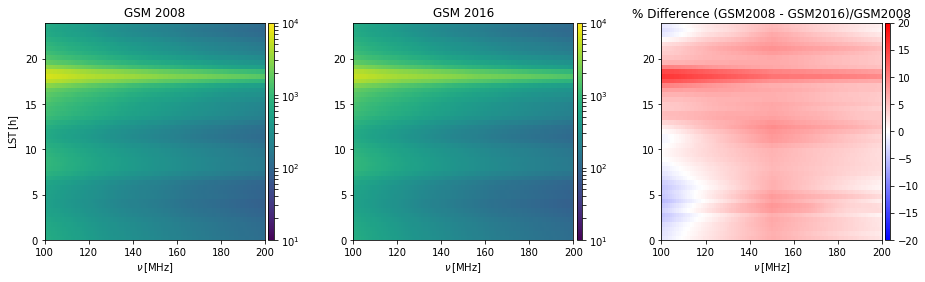

In [319]:
#Read the beam and Sky temperature

#Beam file in fits format
hera_beam_file = "/data4/bharat/Tsys_measurement/NF_HERA_Dipole_power_beam_healpix.fits"

Tsky_g2008 = TskySim(Tsky_file = 'HERA_Tsky-GSM2008_dipole.npz', beam_file = hera_beam_file, f_min=100., f_max=200.)
Tsky_g2016 = TskySim(Tsky_file = 'HERA_Tsky-GSM2016_dipole.npz', beam_file = hera_beam_file, f_min=100., f_max=200.)

Tsky_GSM2008 = (Tsky_g2008.Tsky[0]).T#[0:23,:]
Tsky_GSM2016 = (Tsky_g2016.Tsky[0]).T#[0:23,:]

N_t, N_f = Tsky_GSM2008.shape 

lsts = np.linspace(0,24,N_t)
freqs = np.linspace(100,200,N_f)

diff = Tsky_GSM2008 - Tsky_GSM2016


nu_g, t_g = np.meshgrid(freqs,lsts)

fig1, axs = plt.subplots(nrows=1, ncols=3)
fig1.set_figwidth(15)
fig1.subplots_adjust(wspace=0.4)

axs[0].set_title('GSM 2008')
axs[1].set_title('GSM 2016')
axs[2].set_title('% Difference (GSM2008 - GSM2016)/GSM2008')

axs[0].set_ylabel(r'LST$\,[$h$]$')
axs[0].set_xlabel(r'$\nu\,[$MHz$]$')
axs[1].set_xlabel(r'$\nu\,[$MHz$]$')
axs[2].set_xlabel(r'$\nu\,[$MHz$]$')

im1 = axs[0].pcolormesh(nu_g,t_g,Tsky_GSM2008,norm=LogNorm(vmin=10,vmax=10000)) 
im2 = axs[1].pcolormesh(nu_g,t_g,Tsky_GSM2016,norm=LogNorm(vmin=10,vmax=10000)) 
im3 = axs[2].pcolormesh(nu_g,t_g,100*(diff)/Tsky_GSM2008,cmap='bwr',vmin=-20,vmax=20)#norm=SymLogNorm(linthresh=10,vmin=-500,vmax=1000))

colorbar_plotter(fig1,axs[0],im1,'')
colorbar_plotter(fig1,axs[1],im2,'')
colorbar_plotter(fig1,axs[2],im3,'')

Case 1: $\texttt{data} = G_0 \times T_{sky}[LST] + N_{0} + \epsilon$. 

We use $T_{sky}$ = GSM2008 model, $G_0 = 0.5$, $N_{0} = 100$, and $\epsilon \sim \mathcal{N}(0,\sigma^2 = 100)$ to generate mock $\texttt{data}$. We fit for the parameters $G_{0}$ and $N_0$ using the same GSM2008 sky temperature model.

In this test, we assume that gain and noise bias remain the same in time and frequency and only the sky changes. We also compare variance of recovered $G_{0}$ and $N_0$ with theoretical estimates. 

This is a control test which shows that $T_{rxr}$ is recovered within 5-10% error when using a complete sky temperature model and assuming constant perfect gain and noise bias.

(48, 101)


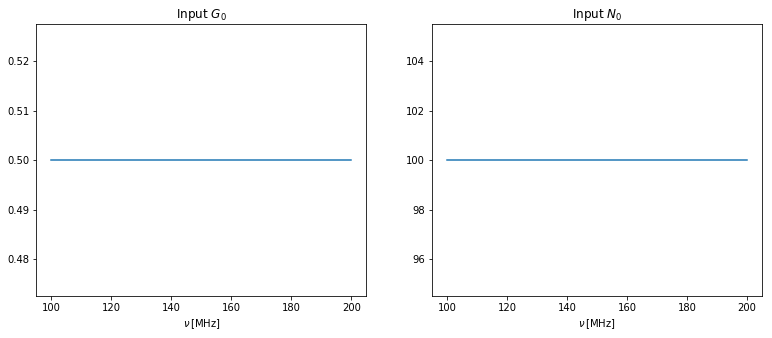

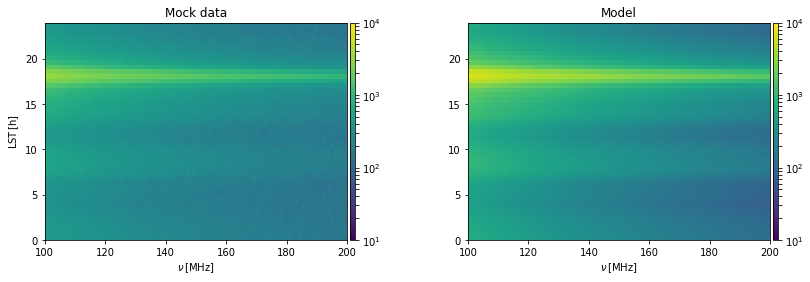

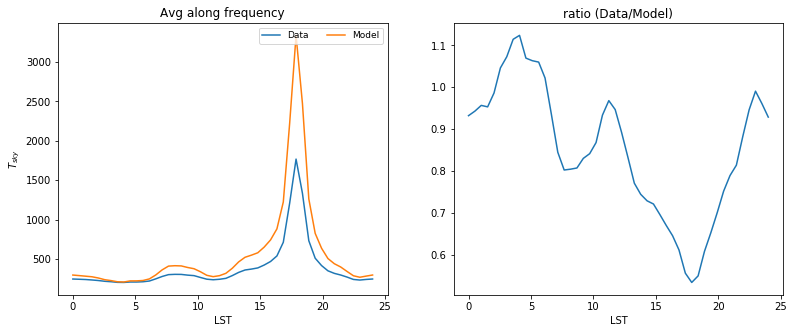

In [322]:
sigma = 10.
Noise = 100.*np.ones((N_f))
G  = 0.5*np.ones((N_f)) #1.+ 0.4*special.yv(2,np.linspace(2.5,10,N_f))

#Create Mock dataset
Tsky_mod = Tsky_GSM2008
Tsky_obs = G[np.newaxis,:]*Tsky_mod + Noise[np.newaxis,:] + np.random.normal(0.,sigma,size=(N_t,N_f)) #model_fit(Tsky_mod,G[np.newaxis,:],Noise[np.newaxis,:])

print Tsky_obs.shape

fig2, axs = plt.subplots(nrows=1,ncols=2)

fig2.set_figwidth(13)
fig2.set_figheight(5)

axs[0].set_title(r'Input $G_0$') 
axs[1].set_title(r'Input $N_0$')

axs[0].set_xlabel(r'$\nu\,[$MHz$]$')
axs[1].set_xlabel(r'$\nu\,[$MHz$]$')

axs[0].plot(freqs,G)
axs[1].plot(freqs,Noise)

fig3, axs = plt.subplots(nrows=1, ncols=2)
fig3.set_figwidth(13)
fig2.set_figheight(5)
fig3.subplots_adjust(wspace=0.4)

axs[0].set_title('Mock data')
axs[1].set_title('Model')

axs[0].set_ylabel(r'LST$\,[$h$]$')
axs[0].set_xlabel(r'$\nu\,[$MHz$]$')
axs[1].set_xlabel(r'$\nu\,[$MHz$]$')


im1 = axs[0].pcolormesh(nu_g,t_g,Tsky_obs,norm=LogNorm(vmin=10,vmax=10000)) 
im2 = axs[1].pcolormesh(nu_g,t_g,Tsky_mod,norm=LogNorm(vmin=10,vmax=10000))

colorbar_plotter(fig3,axs[0],im1,'')
colorbar_plotter(fig3,axs[1],im2,'')


fig4, axs = plt.subplots(nrows=1,ncols=2)

fig4.set_figwidth(13)
fig4.set_figheight(5)
axs[0].set_title('Avg along frequency')
axs[1].set_title('ratio (Data/Model)')

axs[0].set_xlabel(r'LST')
axs[0].set_ylabel(r'$T_{sky}$')

axs[0].plot(lsts,np.mean(Tsky_obs,axis=1),label='Data')
axs[0].plot(lsts,np.mean(Tsky_mod,axis=1),label='Model')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

axs[1].set_xlabel(r'LST')
axs[1].plot(lsts,np.mean(Tsky_obs/Tsky_mod,axis=1))


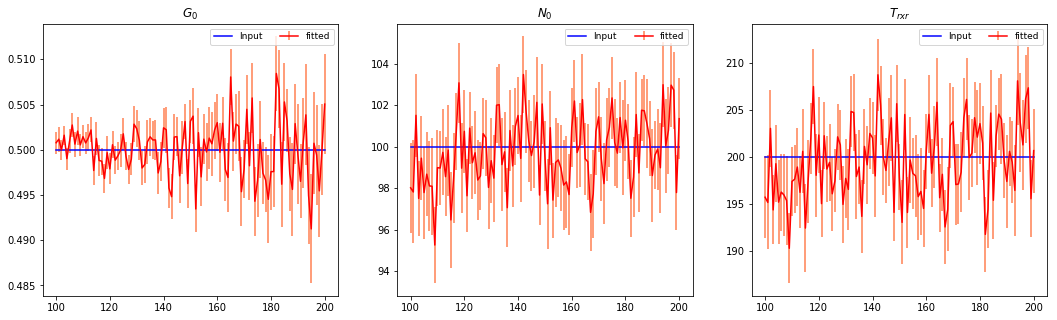

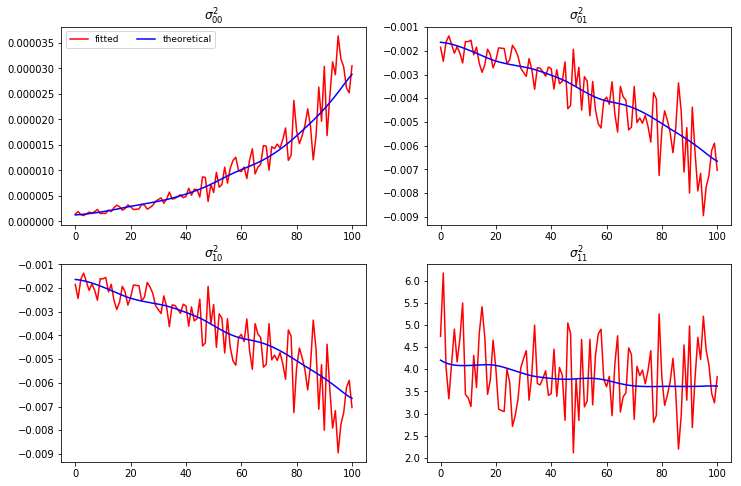

In [323]:
#fitting the data

p_val = np.zeros((2,N_f),dtype=np.float)
p_err = np.zeros((2,N_f),dtype=np.float)
covs  = np.zeros((2,2,N_f),dtype=np.float)


for i in range(N_f):
    
    p_val[:,i],covs[:,:,i] = curve_fit(model_fit,Tsky_mod[:,i],Tsky_obs[:,i],method='lm')#,absolute_sigma=True)
    p_err[:,i] = np.sqrt(np.diag(covs[:,:,i]))

T_rxr = p_val[1,:]/p_val[0,:]    
T_err = T_rxr*np.sqrt((p_err[0,:]/p_val[0,:])**2 + (p_err[1,:]/p_val[1,:])**2)


fig3, axs = plt.subplots(nrows=1,ncols=3)

fig3.set_figwidth(18)
fig3.set_figheight(5)

axs[0].set_title(r'$G_0$') 
axs[1].set_title(r'$N_0$')
axs[2].set_title(r'$T_{rxr}$')

axs[0].plot(freqs,G,'b',label='Input')
axs[0].errorbar(freqs,p_val[0,:],c='r',ecolor='coral',yerr=p_err[0,:],label='fitted')

axs[1].plot(freqs,Noise,'b',label='Input')
axs[1].errorbar(freqs,p_val[1,:],c='r',ecolor='coral',yerr=p_err[1,:],label='fitted')

#axs[2].set_ylim(180,220)

axs[2].plot(freqs,Noise/G,'b',label='Input')
axs[2].errorbar(freqs,T_rxr,c='r',ecolor='coral',yerr=T_err,label='fitted')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')


FI = np.zeros((2,2),dtype=np.float)
Cov = np.zeros((2,2,N_f),dtype=np.float)
for i in range(N_f):
    FI[0,0] = np.sum(Tsky_mod[:,i]**2,axis=0)
    FI[1,0] = np.sum(Tsky_mod[:,i],axis=0)
    FI[0,1] = FI[1,0]
    FI[1,1] = N_t    
    Cov[:,:,i] = np.linalg.inv(np.matrix(FI)/(sigma**2))

fig, axs = plt.subplots(nrows=2,ncols=2)

fig.set_figwidth(12)
fig.set_figheight(8)

axs[0,0].set_title(r'$\sigma^2_{00}$') 
axs[0,1].set_title(r'$\sigma^2_{01}$')
axs[1,0].set_title(r'$\sigma^2_{10}$')
axs[1,1].set_title(r'$\sigma^2_{11}$')

axs[0,0].plot(covs[0,0,:],'r',label='fitted')
axs[0,0].plot(Cov[0,0,:],'b',label='theoretical')

axs[0,1].plot(covs[0,1,:],'r')
axs[0,1].plot(Cov[0,1,:],'b')

axs[1,0].plot(covs[1,0,:],'r')
axs[1,0].plot(Cov[1,0,:],'b')

axs[1,1].plot(covs[1,1,:],'r')
axs[1,1].plot(Cov[1,1,:],'b')

handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles,labels,fontsize=9,ncol=7,loc='upper left')

Case 2: $\texttt{data} = G_0 \times T_{sky}[LST] + N_{0} + \epsilon$. 

In this test we simulate the effect of fitting the auto-correlation data to an inaccurate sky temperature model.

We use $T_{sky}$ = GSM2008 model, $G_0 = 0.5$, $N_{0} = 100$, and $\epsilon \sim \mathcal{N}(0,\sigma^2 = 25)$ to generate $\texttt{data}$ and try to recover $G_{0}$ and $N_0$. However, instead of using GSM2008, we use GSM2016 to fit the mock data. We assume that gain and noise bias remain the same in time and frequency and only the sky changes.  

Note that we use $\epsilon$ with lower variance to reflect the effect of model inaccuracy.

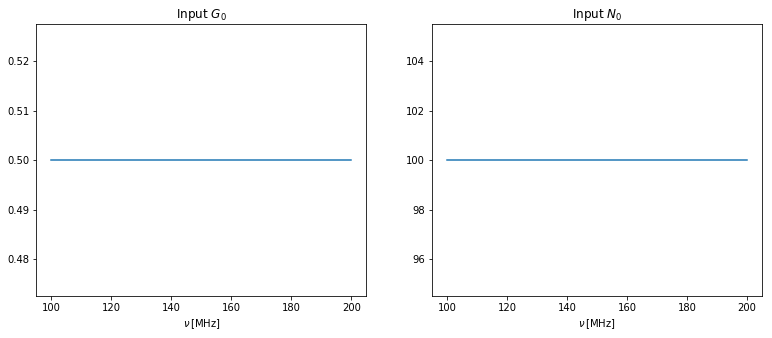

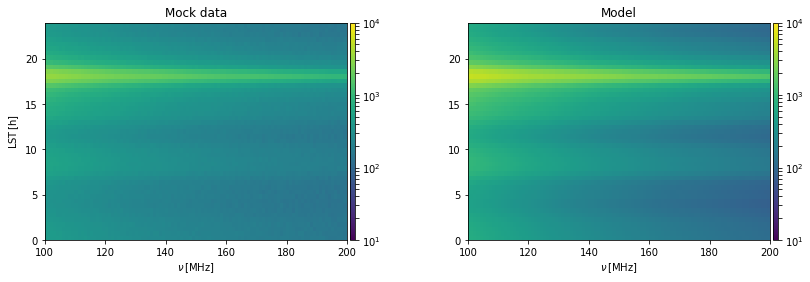

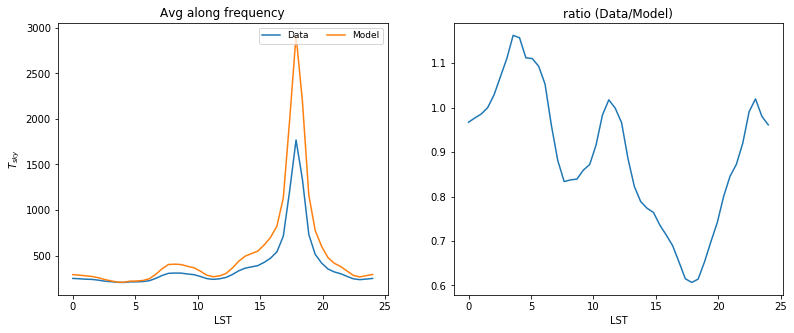

In [329]:
sigma = 5.
Noise = 100.*np.ones((N_f))
G  = 0.5*np.ones((N_f)) #1.+ 0.4*special.yv(2,np.linspace(2.5,10,N_f))

#Create Mock dataset
Tsky_mod = Tsky_GSM2008
Tsky_obs = G[np.newaxis,:]*Tsky_mod + Noise[np.newaxis,:] + np.random.normal(0.,sigma,size=(N_t,N_f))#model_fit(Tsky_mod,G[np.newaxis,:],Noise[np.newaxis,:])
Tsky_mod = Tsky_GSM2016


fig2, axs = plt.subplots(nrows=1,ncols=2)

fig2.set_figwidth(13)
fig2.set_figheight(5)

axs[0].set_title(r'Input $G_0$') 
axs[1].set_title(r'Input $N_0$')

axs[0].set_xlabel(r'$\nu\,[$MHz$]$')
axs[1].set_xlabel(r'$\nu\,[$MHz$]$')

axs[0].plot(freqs,G)
axs[1].plot(freqs,Noise)

fig3, axs = plt.subplots(nrows=1, ncols=2)
fig3.set_figwidth(13)
fig2.set_figheight(5)
fig3.subplots_adjust(wspace=0.4)

axs[0].set_title('Mock data')
axs[1].set_title('Model')

axs[0].set_ylabel(r'LST$\,[$h$]$')
axs[0].set_xlabel(r'$\nu\,[$MHz$]$')
axs[1].set_xlabel(r'$\nu\,[$MHz$]$')


im1 = axs[0].pcolormesh(nu_g,t_g,Tsky_obs,norm=LogNorm(vmin=10,vmax=10000)) 
im2 = axs[1].pcolormesh(nu_g,t_g,Tsky_mod,norm=LogNorm(vmin=10,vmax=10000))

colorbar_plotter(fig3,axs[0],im1,'')
colorbar_plotter(fig3,axs[1],im2,'')


fig4, axs = plt.subplots(nrows=1,ncols=2)

fig4.set_figwidth(13)
fig4.set_figheight(5)
axs[0].set_title('Avg along frequency')
axs[1].set_title('ratio (Data/Model)')

axs[0].set_xlabel(r'LST')
axs[0].set_ylabel(r'$T_{sky}$')

axs[0].plot(lsts,np.mean(Tsky_obs,axis=1),label='Data')
axs[0].plot(lsts,np.mean(Tsky_mod,axis=1),label='Model')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

axs[1].set_xlabel(r'LST')
axs[1].plot(lsts,np.mean(Tsky_obs/Tsky_mod,axis=1))


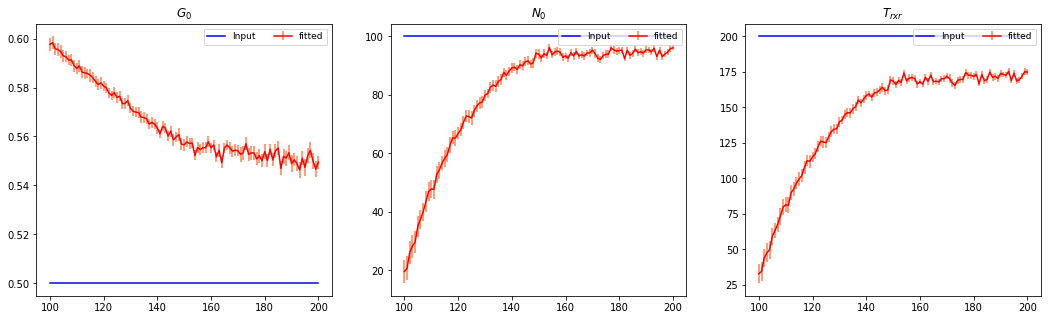

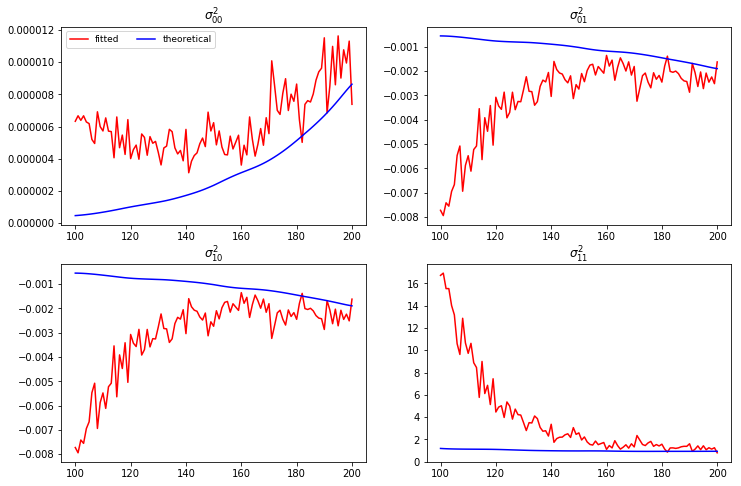

In [330]:
p_val = np.zeros((2,N_f),dtype=np.float)
p_err = np.zeros((2,N_f),dtype=np.float)
covs  = np.zeros((2,2,N_f),dtype=np.float)

for i in range(N_f):
    
    p_val[:,i],covs[:,:,i] = curve_fit(model_fit,Tsky_mod[:,i],Tsky_obs[:,i],method='lm')#,absolute_sigma=True)
    p_err[:,i] = np.sqrt(np.diag(covs[:,:,i]))

T_rxr = p_val[1,:]/p_val[0,:]    
T_err = T_rxr*np.sqrt((p_err[0,:]/p_val[0,:])**2 + (p_err[1,:]/p_val[1,:])**2)

fig3, axs = plt.subplots(nrows=1,ncols=3)

fig3.set_figwidth(18)
fig3.set_figheight(5)

axs[0].set_title(r'$G_0$') 
axs[1].set_title(r'$N_0$')
axs[2].set_title(r'$T_{rxr}$')

axs[0].plot(freqs,G,'b',label='Input')
axs[0].errorbar(freqs,p_val[0,:],c='r',ecolor='coral',yerr=p_err[0,:],label='fitted')

axs[1].plot(freqs,Noise,'b',label='Input')
axs[1].errorbar(freqs,p_val[1,:],c='r',ecolor='coral',yerr=p_err[1,:],label='fitted')

#axs[2].set_ylim(180,220)

axs[2].plot(freqs,Noise/G,'b',label='Input')
axs[2].errorbar(freqs,T_rxr,c='r',ecolor='coral',yerr=T_err,label='fitted')

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles,labels,fontsize=9,ncol=7,loc='upper right')


FI = np.zeros((2,2),dtype=np.float)
Cov = np.zeros((2,2,N_f),dtype=np.float)
for i in range(N_f):
    FI[0,0] = np.sum(Tsky_mod[:,i]**2,axis=0)
    FI[1,0] = np.sum(Tsky_mod[:,i],axis=0)
    FI[0,1] = FI[1,0]
    FI[1,1] = N_t    
    Cov[:,:,i] = np.linalg.inv(np.matrix(FI)/(sigma**2))

fig, axs = plt.subplots(nrows=2,ncols=2)

fig.set_figwidth(12)
fig.set_figheight(8)

axs[0,0].set_title(r'$\sigma^2_{00}$') 
axs[0,1].set_title(r'$\sigma^2_{01}$')
axs[1,0].set_title(r'$\sigma^2_{10}$')
axs[1,1].set_title(r'$\sigma^2_{11}$')

axs[0,0].plot(freqs,covs[0,0,:],'r',label='fitted')
axs[0,0].plot(freqs,Cov[0,0,:],'b',label='theoretical')

axs[0,1].plot(freqs,covs[0,1,:],'r')
axs[0,1].plot(freqs,Cov[0,1,:],'b')

axs[1,0].plot(freqs,covs[1,0,:],'r')
axs[1,0].plot(freqs,Cov[1,0,:],'b')

axs[1,1].plot(freqs,covs[1,1,:],'r')
axs[1,1].plot(freqs,Cov[1,1,:],'b')

handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,0].legend(handles,labels,fontsize=9,ncol=7,loc='upper left')
        

In this test, it is clear that an incomplete sky temperature model can introduce a significant bias in the fitting process. Although the dfference between GSM2008 and GSM2016 models at various LSTs and frequencies is ~5-10%, it can bias the result by several times. The difference between two models shows larger variations at lower frequencies, which translates into the fitting process and produce biased estimates. 